In [ ]:
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", UserWarning)

import random
import time
from datetime import datetime
from itertools import product
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MaxAbsScaler
from tqdm.auto import tqdm

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape
from darts.models import (
    ARIMA,
    ExponentialSmoothing,
    KalmanForecaster,
    LightGBMModel,
    LinearRegressionModel,
    NaiveSeasonal,
    NBEATSModel,
    RandomForestModel,
    Theta,
)
from darts.utils.losses import SmapeLoss
from utily_old import * 

In [2]:
HORIZON = 18

In [3]:
def eval_forecasts(
    pred_series: list[TimeSeries], test_series: list[TimeSeries]
) -> list[float]:
    print("computing sMAPEs...")
    smapes = smape(test_series, pred_series)
    plt.figure()
    plt.hist(smapes, bins=50)
    plt.ylabel("Count")
    plt.xlabel("sMAPE")
    plt.title(f"Median sMAPE: {np.nanmedian(smapes):.3f}")
    plt.show()
    plt.close()
    return smapes

In [4]:
air_train, air_test = load_air(HORIZON=HORIZON)

                    Total
carrier data_dte         
02Q     01/01/2008    132
        01/01/2011     15
        01/01/2012     15
        01/01/2013    210
        01/01/2017    104
...                   ...
ZX      12/01/2015  35964
        12/01/2016  78746
        12/01/2017  85693
        12/01/2018  73465
        12/01/2019  19327

[70159 rows x 1 columns]
splitting train/test...
scaling series...
done. There are 249 series, with average training length 152.7710843373494


In [ ]:
df = pd.read_csv("carrier_passengers.csv")
    # extract relevant columns
df = df[["data_dte", "carrier", "Total"]]
    # aggregate per carrier and date
df = pd.DataFrame(df.groupby(["carrier", "data_dte"]).sum())

df = df.reset_index()



TimeSeries.from_group_dataframe(
        df, group_cols="carrier", time_col="data_dte", value_cols="Total", freq="MS"
    )






,carrier,data_dte,Total
0,02Q,01/01/2008,132
1,02Q,01/01/2011,15
2,02Q,01/01/2012,15
3,02Q,01/01/2013,210
4,02Q,01/01/2017,104
...,...,...,...
70154,ZX,12/01/2015,35964
70155,ZX,12/01/2016,78746
70156,ZX,12/01/2017,85693
70157,ZX,12/01/2018,73465


In [22]:
air_train[0].values().flatten()+10

array([10.299873 , 10.346739 , 10.442052 , 10.485117 , 10.526599 ,
       10.234325 , 10.276441 , 10.276441 , 10.125079 , 10.125079 ,
       10.015516 , 10.124446 , 10.184294 , 10.485117 , 10.537365 ,
       10.346739 , 10.360988 , 10.475617 , 10.339772 , 10.2077265,
       10.19506  , 10.171945 , 10.071565 , 10.183027 , 10.442685 ,
       10.572515 , 10.68651  , 10.6836605, 10.7707405, 10.533882 ,
       10.425586 , 10.311589 , 10.21596  , 10.207093 , 10.087714 ,
       10.161811 , 10.616213 , 10.572831 , 10.831223 , 10.716593 ,
       10.833122 , 10.400253 , 10.487333 , 10.320456 , 10.362254 ,
       10.287523 , 10.12223  , 10.217543 , 10.689044 , 10.691577 ,
       10.819506 , 10.838189 , 10.8793545, 10.705827 , 10.482267 ,
       10.383471 , 10.371438 , 10.282774 , 10.166561 , 10.128245 ,
       10.230526 , 10.526916 , 10.615896 , 10.679228 , 11.       ,
       10.672578 , 10.504116 , 10.410069 ], dtype=float32)

In [24]:
df_mock = pd.DataFrame({'carrier':['mock']*len(air_train[0].values()),
                        'data_dte':air_train[0].time_index.values,
                        'Total':air_train[0].values().flatten()+10})
TimeSeries.from_group_dataframe(
        df_mock, group_cols="carrier", time_col="data_dte", value_cols="Total", freq="MS"
    )

[                Total
 data_dte             
 2012-11-01  10.299873
 2012-12-01  10.346739
 2013-01-01  10.442052
 2013-02-01  10.485117
 2013-03-01  10.526599
 ...               ...
 2018-02-01  10.679228
 2018-03-01  11.000000
 2018-04-01  10.672578
 2018-05-01  10.504116
 2018-06-01  10.410069
 
 shape: (68, 1, 1), freq: MS, size: 272.00 B
 
 Static covariates:
     static_covariates carrier
     Total                mock]

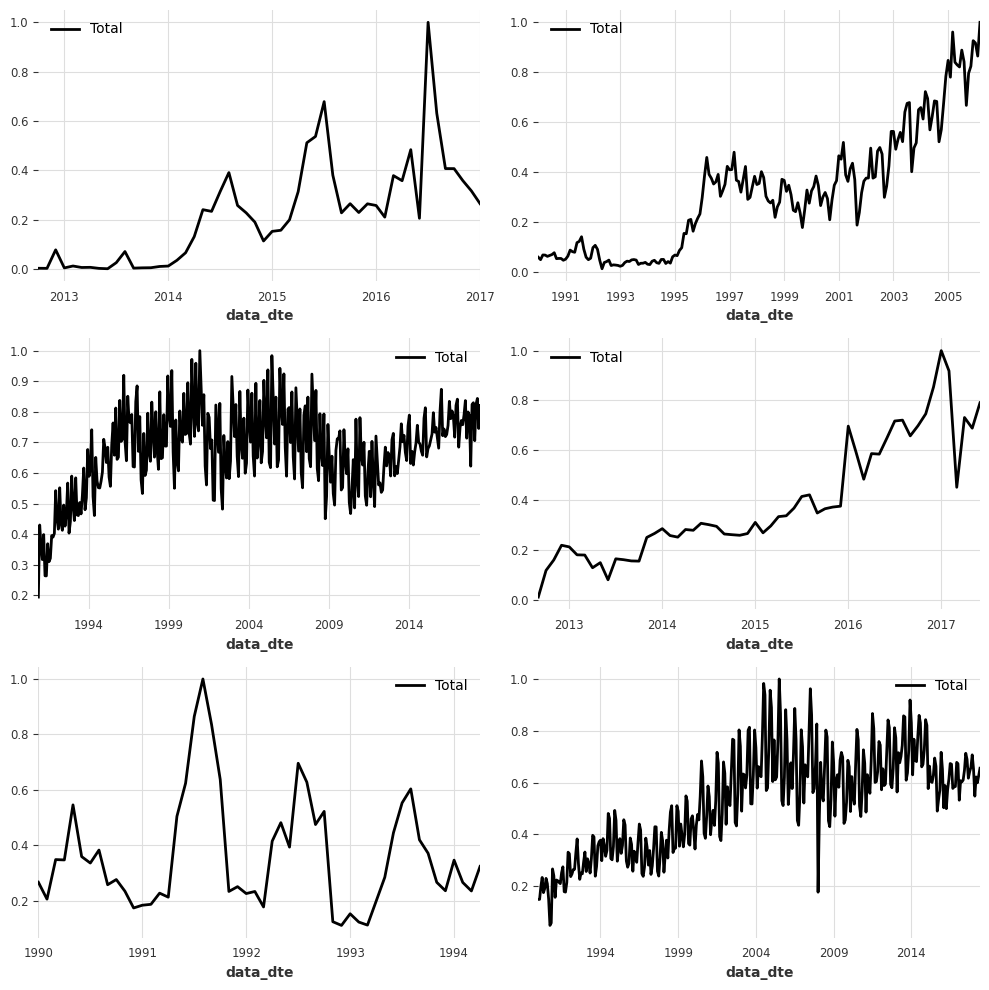

In [5]:
figure, ax = plt.subplots(3, 2, figsize=(10, 10), dpi=100)

for i, idx in enumerate([1, 20, 50, 100, 150, 200]):
    axis = ax[i % 3, i % 2]
    air_train[idx].plot(ax=axis)
    axis.legend(air_train[idx].components)
    axis.set_title("")
plt.tight_layout()

In [6]:
def eval_local_model(
    train_series: list[TimeSeries], test_series: list[TimeSeries], model_cls, **kwargs
) -> tuple[list[float], float]:
    preds = []
    start_time = time.time()
    for series in tqdm(train_series):
        model = model_cls(**kwargs)
        model.fit(series)
        pred = model.predict(n=HORIZON)
        preds.append(pred)
    elapsed_time = time.time() - start_time

    smapes = eval_forecasts(preds, test_series)
    return smapes, elapsed_time

100%|██████████| 249/249 [00:00<00:00, 6043.18it/s]


computing sMAPEs...


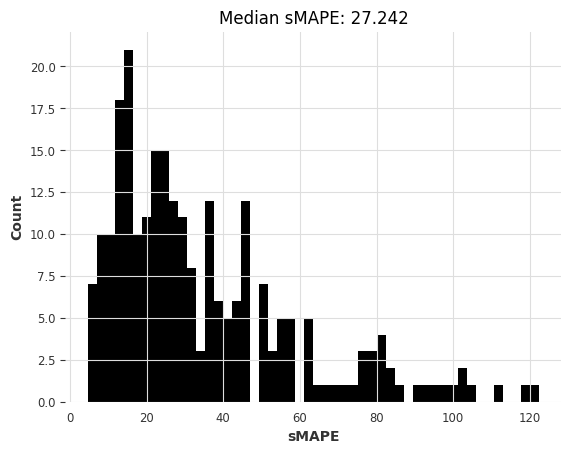

In [7]:
naive1_smapes, naive1_time = eval_local_model(air_train, air_test, NaiveSeasonal, K=1)

In [16]:
import numpy as np
import pandas as pd

class FrequencyDomainProcessor:
    """
    A class to transform a 1D time-series signal from a DataFrame
    to the frequency domain, modify it, and reconstruct it back.
    """
    def __init__(self, df, signal_col, sampling_rate):
        """
        Initialize the processor.

        Parameters
        ----------
        df : pandas.DataFrame
            The dataframe containing the signal.
        signal_col : str
            The column name with the signal values.
        sampling_rate : float
            Sampling frequency in Hz.
        """
        self.df = df.copy()
        self.signal_col = signal_col
        self.fs = sampling_rate

        # Extract signal and time
        self.signal = self.df[signal_col].values
        self.N = len(self.signal)
        self.freqs = np.fft.fftfreq(self.N, d=1/self.fs)
        self.fft_signal = None
        self.modified_fft = None
        self.reconstructed_signal = None
        self.noise = None
        #self.filter_type = None

    def fft(self):
        """Compute FFT of the signal and store it."""
        self.fft_signal = np.fft.fft(self.signal,norm='ortho')#/(len(self.signal)/2)
        return self.fft_signal, self.freqs

    def apply_filter(self, filter_type='lowpass', cutoff=None,noise_level =0.10,mask=None):
        """
        Modify the signal in the frequency domain.

        Parameters
        ----------
        filter_type : str
            One of {'lowpass', 'highpass', 'bandpass'}.
        cutoff : float or tuple
            Cutoff frequency/frequencies (Hz).
            - lowpass: single value (e.g. 100)
            - highpass: single value (e.g. 100)
            - bandpass: tuple (low, high)
        """
        self.filter_type = filter_type

        if self.fft_signal is None:
            raise ValueError("Run fft() before filtering.")

        X_mod = self.fft_signal.copy()#/(len(self.fft_signal/2))
        f = np.abs(self.freqs)
        #print(len(f))

        if filter_type == 'lowpass':
            X_mod[f > cutoff] = 0
        elif filter_type == 'highpass':
            X_mod[f < cutoff] = 0
        elif filter_type =='Mask':
            X_mod[mask] = 0
        elif filter_type == 'bandpass':
            if not isinstance(cutoff, (list, tuple)) or len(cutoff) != 2:
                raise ValueError("For bandpass, cutoff must be (low, high).")
            low, high = cutoff
            X_mod[(f < low) | (f > high)] = 0
        elif filter_type =="noise":
            np.random.seed(0)
            noise = np.random.normal(0,noise_level,size=len(X_mod))#(np.random.rand(len(X_mod)) - 0.5) * np.max(np.abs(X_mod)) * noise_level 
            X_mod += noise
            self.noise = noise
        else:
            raise ValueError("Invalid filter_type. Use 'lowpass', 'highpass', or 'bandpass'.")

        self.modified_fft = X_mod
        return X_mod

    def ifft(self):
        """Reconstruct the time-domain signal from the modified FFT."""
        if self.modified_fft is None:
            raise ValueError("No modified FFT found. Run apply_filter() first.")
        self.reconstructed_signal = np.real(np.fft.ifft(self.modified_fft, norm='ortho'))#*(len(self.modified_fft)/2)))
        self.df[self.signal_col + '_filtered'] = self.reconstructed_signal
        if self.filter_type == 'noise':
            self.df['noise_time_domain'] = np.real(np.fft.ifft(self.noise,norm='ortho'))
        return self.reconstructed_signal

    def get_filtered_dataframe(self):
        """Return the DataFrame containing the original and filtered signals."""
        if self.reconstructed_signal is None:
            raise ValueError("Reconstructed signal not found. Run ifft() first.")
        return self.df


37
37
37


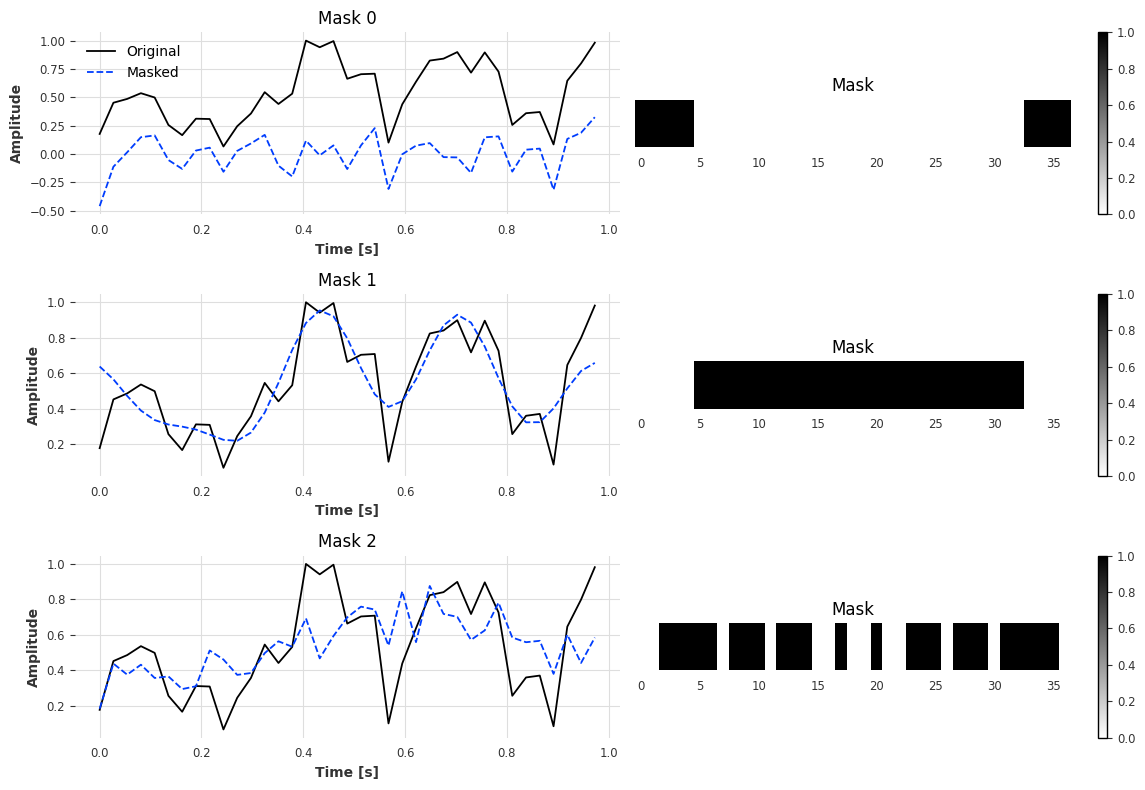

In [28]:
df = pd.DataFrame({'Value':air_train[15].values().flatten()})

from scipy.stats import wasserstein_distance





fig, ax = plt.subplots(3,2,figsize=(12,8))
# Process it

maks1 = np.random.choice([False,True],len(df)//2,replace=True)
mask = mask = np.hstack((maks1,np.array(list(reversed(maks1)))))
NOISE = [10,2,1]
for i in range(3):
    if i == 0:
        mask = np.array([True]* 5 + [False]*int((np.ceil(len(df)/2)-5)) + [False]*int((np.ceil(len(df)/2)-5)) + [True]*5)
        j = int(len(df)/2)- int(np.ceil(len(df)/2))
        if j!= 0:
            mask = mask[:-1]
    elif i ==1:
        mask = np.array([False]* 5 + [True]*int((np.ceil(len(df)/2)-5)) + [True]*int((np.ceil(len(df)/2)-5)) + [False]*5)
        j = int(len(df)/2)- int(np.ceil(len(df)/2))
        if j!= 0:
            mask = mask[:-1]
    else:
        maks1 = np.random.choice([False,True],int(np.ceil(len(df)/2)),replace=True)
        j = int(len(df)/2)- int(np.ceil(len(df)/2))       
        if j!=0:   
            mask = np.hstack((maks1,np.array(list(reversed(maks1)))))[:-1]
        else:
            mask = np.hstack((maks1,np.array(list(reversed(maks1)))))
        
    processor = FrequencyDomainProcessor(df, signal_col='Value', sampling_rate=len(df))
    processor.fft()
    processor.apply_filter(filter_type='Mask', cutoff=NOISE[i],noise_level=NOISE[i],mask=mask)
    processor.ifft()
    df_filtered = processor.get_filtered_dataframe()
    #print(df_filtered.head())
    # Plot
    dt = np.linspace(0, 1, len(df), endpoint=False)
    #plt.figure(figsize=(10,5))
    ax[i,0].plot(dt, df['Value'], label='Original')
    ax[i,0].plot(dt, df_filtered['Value_filtered'], label='Masked', linestyle='--')
    #plt.legend()
    ax[i,0].set_xlabel("Time [s]")
    ax[i,0].set_ylabel("Amplitude")
    #plt.title("Time Series")
    #plt.show()
    ax[i,0].set_title(f"Mask {i}")

    
    #ax[i,1].plot(processor.fft_signal,label='freq-clean')
    #ax[i,1].plot(processor.modified_fft,label='freq-noise')
    img = ax[i,1].imshow(mask.repeat(4).reshape(len(df),4).T,cmap='binary')
    ax[i,1].grid(False)
    fig.colorbar(img,ax=ax[i,1])
    

    wd = wasserstein_distance(np.abs(processor.fft_signal), np.abs(processor.modified_fft))
    ax[i,1].set_title(f"Mask")
    ax[i,1].set_yticks([])
        
ax[0,0].legend()
plt.tight_layout()


In [ ]:
def eval_local_model_masked(
    train_series: list[TimeSeries], test_series: list[TimeSeries], model_cls, **kwargs
) -> tuple[list[float], float]:
    preds = []
    start_time = time.time()
    for series in tqdm(train_series):
        model = model_cls(**kwargs)

        
        df = pd.DataFrame({'Value':series.values().flatten()})
        K = 15
        mask = np.array([False]*K+ [True]*int((np.ceil(len(df)/2)-K)) + [True]*int((np.ceil(len(df)/2)-K)) + [False]*K)
        j = int(len(df)/2)- int(np.ceil(len(df)/2))
        if j!= 0:
            mask = mask[:-1]
        processor = FrequencyDomainProcessor(df, signal_col='Value', sampling_rate=len(df))
        processor.fft()
        processor.apply_filter(filter_type='noise', cutoff=0,noise_level=0.05,mask=mask)
        processor.ifft()
        df_filtered = processor.get_filtered_dataframe()
        #print(len(series.time_index.values))

        df_mock = pd.DataFrame({'carrier':['mock']*len(series.values()),
                        'data_dte':series.time_index.values,
                        'Total':df_filtered['Value_filtered'].values.flatten()})
        series_filtered = TimeSeries.from_group_dataframe(
        df_mock, group_cols="carrier", time_col="data_dte", value_cols="Total", freq="MS"
    )
        
        model.fit(series_filtered[0])
        pred = model.predict(n=HORIZON)
        preds.append(pred)
    elapsed_time = time.time() - start_time

    smapes = eval_forecasts(preds, test_series)
    return smapes, elapsed_time

100%|██████████| 249/249 [02:15<00:00,  1.84it/s]

computing sMAPEs...


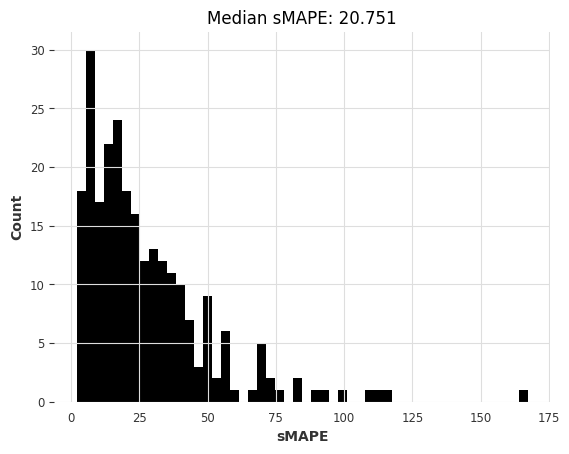

In [37]:
#naive1_smapes, naive1_time = eval_local_model_masked(air_train, air_test, NaiveSeasonal, K=1)
#ets_smapes, ets_time = eval_local_model(air_train, air_test, ExponentialSmoothing)
warnings.filterwarnings("ignore")  # ARIMA generates lots of warnings
arima_smapes, arima_time = eval_local_model(air_train, air_test, ARIMA, p=12, d=1, q=1)

100%|██████████| 249/249 [02:08<00:00,  1.94it/s]

computing sMAPEs...


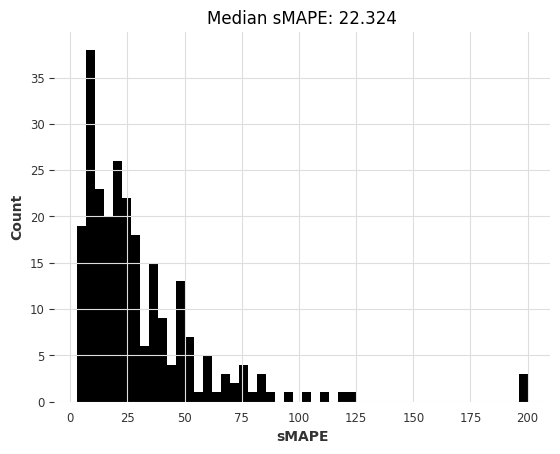

In [36]:
warnings.filterwarnings("ignore")  # ARIMA generates lots of warnings
arima_smapes, arima_time = eval_local_model_masked(air_train, air_test, ARIMA, p=12, d=1, q=1)